# Vehicle-agnostic scene processing for information embedding.

Input data: processed vehicle groups from the highD dataset. See dataviz.ipynb for more info.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import seaborn as sns

from copy import copy
from IPython.display import HTML
from matplotlib.patches import Rectangle, Ellipse
from pprint import pprint
from rich import print
from sys import platform
from time import time

from read_csv import read_groups

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")

%matplotlib widget

In [2]:
if platform == 'darwin':
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/highD/groups_1000ms/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/highD/groups_1000ms/"
dataset_index = 1 #between 1 and 60
df_groups_list = read_groups(dataset_location + str(dataset_index).zfill(2) + "_groups.csv")

In [8]:
class PotentialField:
    def __init__(self, radius_x, radius_y, step_x, step_y, vehicle_group):
        self.rx, self.ry = radius_x, radius_y
        self.sx, self.sy = step_x, step_y
        self.vehicle_group = vehicle_group

        self.grid= self.initialize_grid()
        self.vehicle_list = self.group_to_list()
        self.vehicle_count = len(self.vehicle_list)
        self.ego_vehicle = self.vehicle_list[0]
        self.x_ego, self.y_ego = self.ego_vehicle["x"], self.ego_vehicle["y"]

    def initialize_grid(self):
        #calculate grid size
        self.num_x = int(2*self.rx / self.sx) + 1
        self.num_y = int(2*self.ry / self.sy) + 1
        self.grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        self.x_pos, self.y_pos = np.linspace(-self.rx, self.rx, self.num_x), np.linspace(-self.ry, self.ry, self.num_y) #x and y interchanged so x is the horizontal dimension, and y is the vertical dimension
        print("Initialized grid of shape: {}".format(self.grid.shape))
        return self.grid

    def group_to_list(self):
        self.vehicle_list = self.vehicle_group.to_dict(orient='records')
        for idx, vehicle in enumerate(self.vehicle_list):
            for k, v in vehicle.items():
                self.vehicle_list[idx][k] = float(v)
        return self.vehicle_list
    
    def get_field_value(self, dx, dy, vehicle):
        ang = np.arctan2(vehicle["xVelocity"], vehicle["yVelocity"])
        speed = np.linalg.norm([vehicle["xVelocity"], vehicle["yVelocity"]])
        sigma_y, sigma_x = vehicle["width"], vehicle["height"]/2

        a = np.square(np.cos(ang)) / (2 * np.square(sigma_x)) + np.square(np.sin(ang)) / (2 * np.square(sigma_y))
        b = - np.sin(2 * ang) / (4 * np.square(sigma_x)) + np.sin(2 * ang) / (4 * np.square(sigma_y))
        c = np.square(np.sin(ang)) / (2 * np.square(sigma_x)) + np.square(np.cos(ang)) / (2 * np.square(sigma_y))

        field = speed * np.exp(-(a * np.square(dx) + 2 * b * dx * dy + c * np.square(dy)))
        return field
    
    def calculate_field_at_point(self, x, y):
        field_value = 0
        for vehicle in self.vehicle_list:
            x_rel = vehicle["x"] - self.x_ego
            y_rel = - vehicle["y"] + self.y_ego #positive y direction points "downwards"
            dx, dy = x - x_rel, y - y_rel
            field_value += self.get_field_value(dx, dy, vehicle)
            #print("Vehicle {} - Point ({},{}) - Field value = {}".format(vehicle["id"], x, y, field_value))
        return field_value
    
    def calculate_field(self):
        for i, x in enumerate(self.x_pos):
            for j, y in enumerate(self.y_pos):
                self.grid[j][i] = self.calculate_field_at_point(x, y)
        self.normalized_grid = self.grid / np.linalg.norm(self.grid, 'fro')
        self.normalized_grid = (self.normalized_grid - np.min(self.normalized_grid)) / (np.max(self.normalized_grid) - np.min(self.normalized_grid))
        return self.normalized_grid
    
    def plot_field(self):
        fig = plt.figure(figsize=(15, 8))

        #plot 3d field
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        X, Y = np.meshgrid(self.x_pos, self.y_pos)
        surf = ax3d.plot_surface(X, Y, self.normalized_grid, cmap = "viridis")
        ax3d.set_xlabel("Longitudinal axis (m)")
        ax3d.set_ylabel("Transversal axis (m)")
        ax3d.set_zlabel("Potential field magnitude (-)")
        ax3d.set_title("3d plot - Normalized between 0 and 1".format(int(self.ego_vehicle["frame"])))
        fig.colorbar(surf, orientation = 'horizontal', pad = 0.2)

        #plot heatmap
        ax2d = fig.add_subplot(1, 2, 2)
        img = ax2d.imshow(self.normalized_grid)
        ax2d.set_xlabel("Longitudinal axis (px)")
        ax2d.set_ylabel("Transversal axis (px)")
        ax2d.set_title("Potential field heat map - Frame {}".format(int(self.ego_vehicle["frame"])))
        fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

        fig.suptitle("Potential field representation - Frame {}".format(int(self.ego_vehicle["frame"])))
        plt.show()

    def plot_center_field(self):
        fig, ax = plt.subplots()
        y_index = int((self.normalized_grid.shape[0] - 1) / 2)
        x = self.x_pos
        y = self.normalized_grid[y_index]
        ax.plot(x, y)
        ax.set_xlabel("Transversal axis (m)")
        ax.set_ylabel("Potential field magnitude (-)")
        ax.set_title("Ego vehicle longitudinal axis - Frame {}".format(int(self.ego_vehicle["frame"])))

        plt.show()

    def plot_heat_map(self):
        fig, ax = plt.subplots()
        ax.imshow(self.normalized_grid)
        ax.set_xlabel("Longitudinal axis (m)")
        ax.set_ylabel("Transversal axis (m)")
        ax.set_title("Potential field heat map - Frame {}".format(int(self.ego_vehicle["frame"])))
        plt.show()

In [13]:
rx = 50 # horizontal semiaxis of ellipse to consider as ROI
ry = 6 # vertical semiaxis of ellipse to consider as ROI
sx = 1
sy = 0.2
vehicle_group = df_groups_list[np.random.randint(len(df_groups_list))]
display(vehicle_group)

,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,precedingXVelocity,precedingId,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId
Index,,,,,,,,,,,,,,,,,,,,,
234326,14626,698,338.71,9.48,4.55,1.92,-26.85,0.08,-0.02,0.01,...,-24.05,694,701,699,0,700,0,0,0,2
234011,14626,697,300.88,13.19,4.55,1.92,-31.51,0.11,0.26,-0.07,...,-31.1,696,699,0,0,0,694,0,698,3
234716,14626,699,326.57,13.37,4.45,1.92,-31.67,0.09,0.54,-0.03,...,-31.51,697,700,0,0,0,694,0,698,3
235014,14626,700,369.49,13.48,4.55,1.92,-30.61,-0.02,-0.62,0.1,...,-31.67,699,702,0,0,0,698,0,701,3
235337,14626,701,380.87,9.22,4.35,1.92,-28.3,-0.0,0.17,0.06,...,-26.85,698,0,700,0,702,0,0,0,2


Initialized grid of shape: (61, 101)

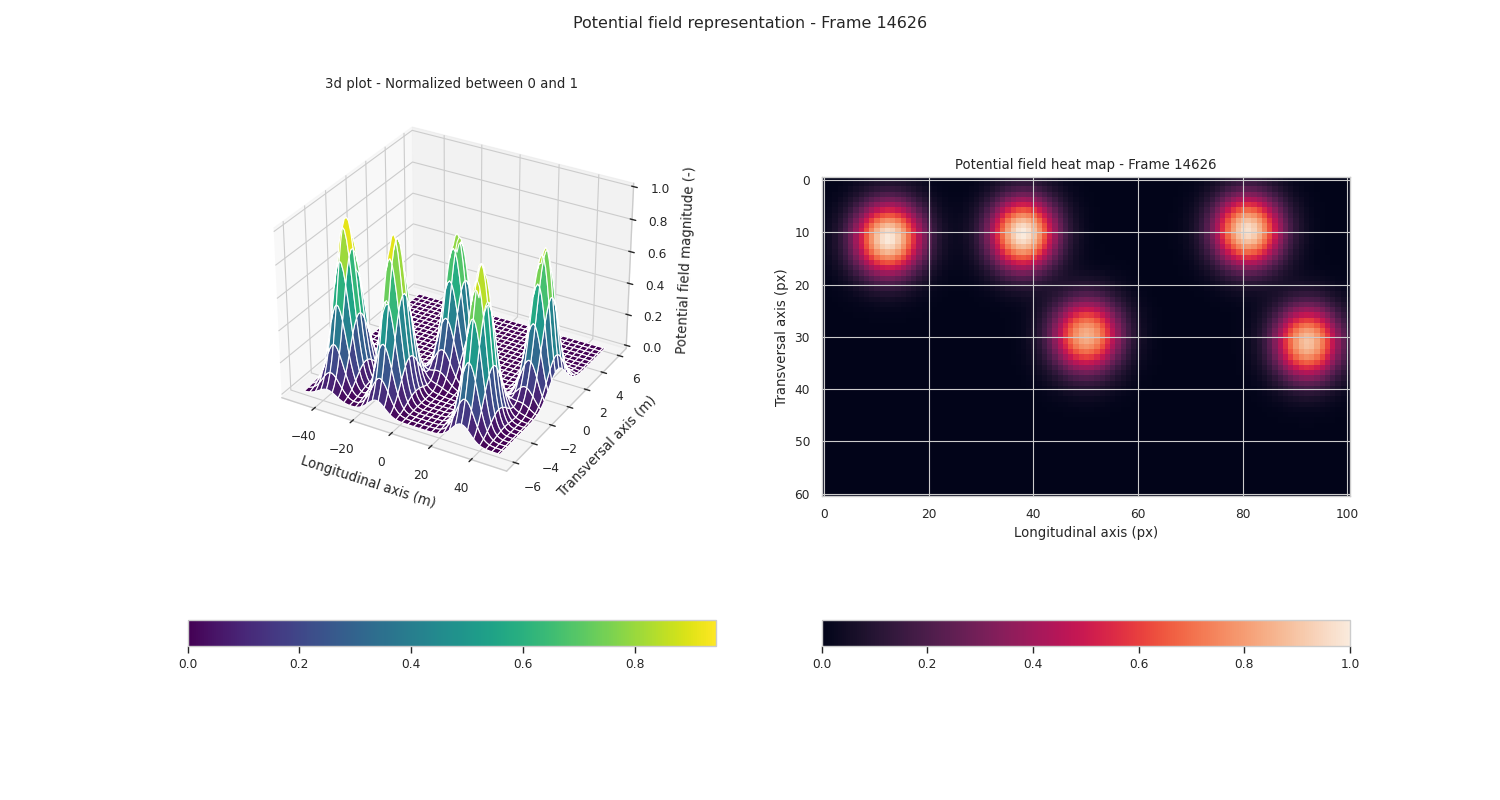

In [14]:
field = PotentialField(rx, ry, sx, sy, vehicle_group)
values = field.calculate_field()
plt.close()
field.plot_field()

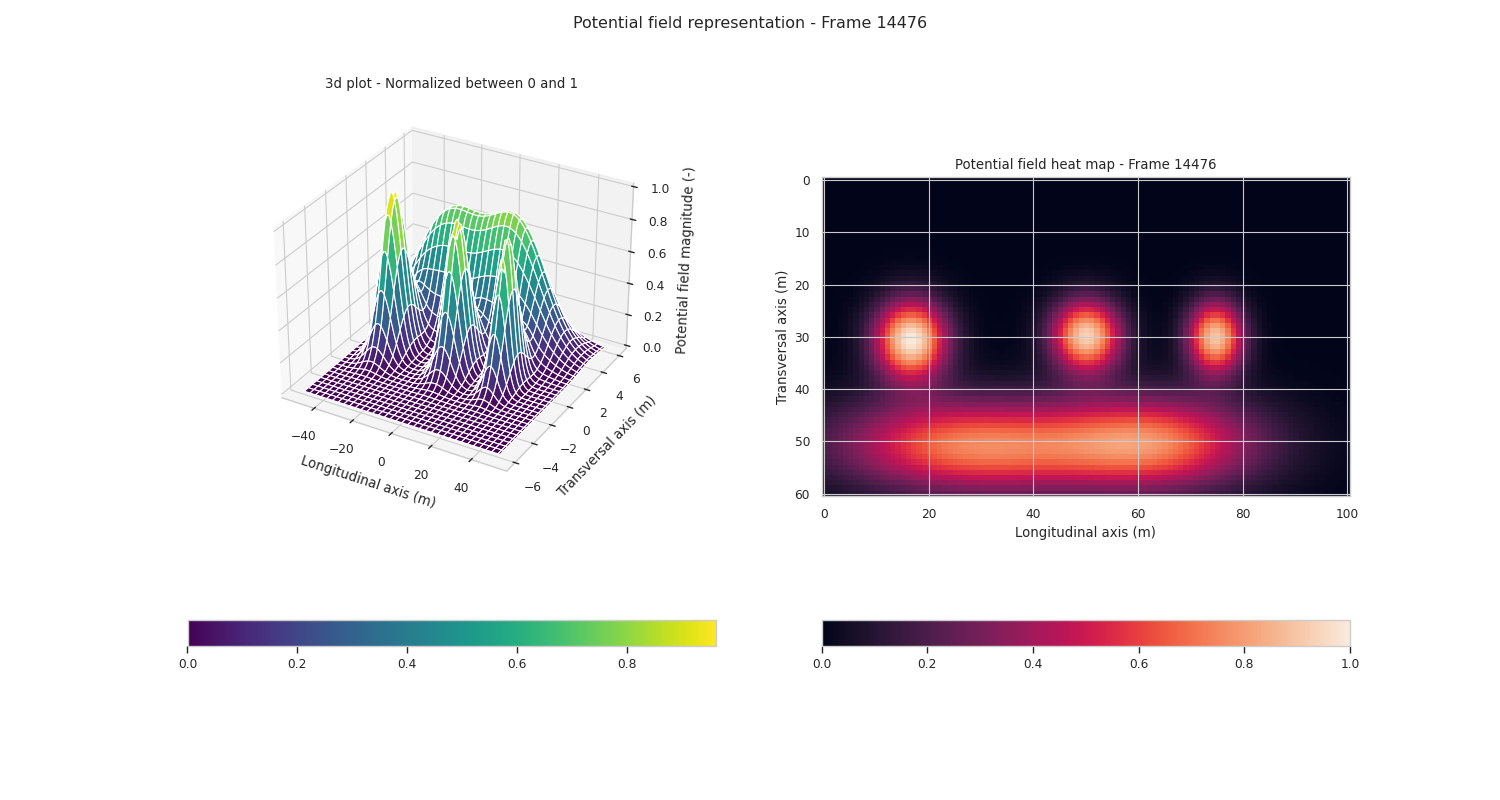

In [14]:
values = field.calculate_field()
plt.close()
field.plot_field()

In [33]:
[print(vehicle["width"], vehicle["height"]) for vehicle in field.vehicle_list]
plt.close('all')

3.64 1.82

3.54 1.82

4.65 2.02